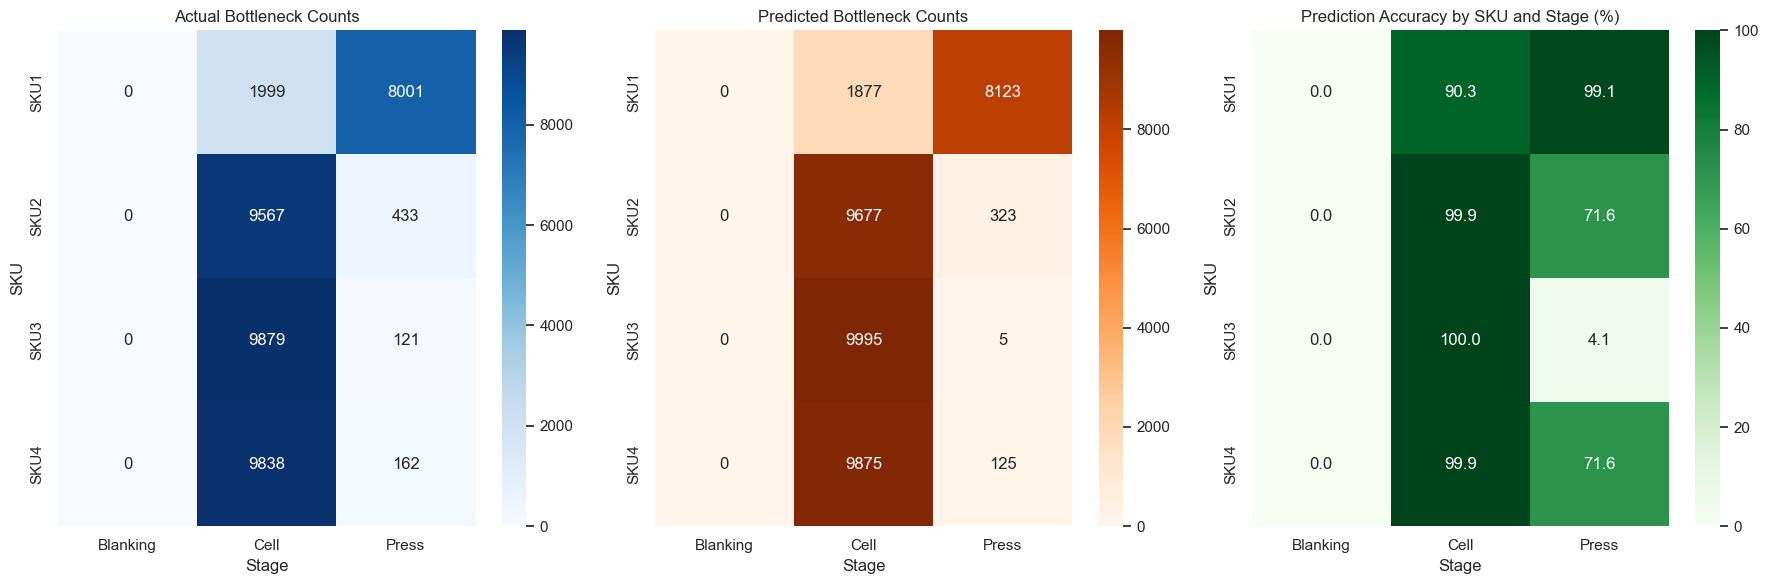

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# ================================
# 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
# ================================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ================================
# 2. SKU Í≤ΩÎ°ú Î∞è Cell Îß§Ìïë Ï†ïÏùò
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],  # Cell1
    "Warehouse_2_Queue": ["SKU2", "SKU4"],         # Cell2
    "Warehouse_3_Queue": ["SKU2", "SKU3"],         # Cell3
    "Warehouse_4_Queue": ["SKU3", "SKU4"],         # Cell4
}

# ================================
# 3. Warehouse Î∂ÑÎ∞∞ Î≤°ÌÑ∞Ìôî
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. Î≥ëÎ™© Stage ÎùºÎ≤® ÏÉùÏÑ± (Î≤°ÌÑ∞Ìôî)
# ================================
labels = {}
for sku, path in sku_paths.items():
    blanking = df[path["blanking"]]
    press = df[path["press"]]
    cell = sku_cell_vals[sku]
    stage_df = pd.DataFrame({"Blanking": blanking, "Press": press, "Cell": cell})
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Feature ÏÑ†ÌÉù
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X_full = df[feature_cols]

# ÏÜçÎèÑ ÏúÑÌï¥ ÏÉòÌîåÎßÅ (ÌïÑÏöî Ïãú sample_size Ï°∞Ï†à)
sample_size = 50000
df_sample = df.sample(n=sample_size, random_state=42)
X = df_sample[feature_cols]

# ================================
# 6. ÌïôÏäµ + ÏßëÍ≥Ñ
# ================================
acc_records, actual_records, pred_records = [], [], []

for sku in sku_paths.keys():
    y = labels[sku].loc[df_sample.index]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    clf = RandomForestClassifier(
        n_estimators=100, max_depth=15, random_state=42, n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy per Stage
    cm = confusion_matrix(y_test, y_pred, labels=["Blanking","Press","Cell"])
    acc = np.divide(cm.diagonal(), cm.sum(axis=1),
                    out=np.zeros_like(cm.diagonal(), dtype=float),
                    where=cm.sum(axis=1)!=0)
    for stage, val in zip(["Blanking","Press","Cell"], acc):
        acc_records.append({"SKU": sku, "Stage": stage, "Accuracy": val})

    # Stage Counts
    true_counts = pd.Series(y_test).value_counts()
    pred_counts = pd.Series(y_pred).value_counts()
    for stage in ["Blanking","Press","Cell"]:
        actual_records.append({"SKU": sku, "Stage": stage, "Count": true_counts.get(stage,0)})
        pred_records.append({"SKU": sku, "Stage": stage, "Count": pred_counts.get(stage,0)})

# Pivot Î≥ÄÌôò
acc_df = pd.DataFrame(acc_records).pivot(index="SKU", columns="Stage", values="Accuracy")
actual_counts = pd.DataFrame(actual_records).pivot(index="SKU", columns="Stage", values="Count")
pred_counts = pd.DataFrame(pred_records).pivot(index="SKU", columns="Stage", values="Count")

# ================================
# 7. Dashboard Plot (3Ìå®ÎÑê)
# ================================
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.heatmap(actual_counts, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Actual Bottleneck Counts")

sns.heatmap(pred_counts, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Predicted Bottleneck Counts")

sns.heatmap(acc_df*100, annot=True, fmt=".1f", cmap="Greens", ax=axes[2])
axes[2].set_title("Prediction Accuracy by SKU and Stage (%)")

plt.tight_layout()
plt.show()

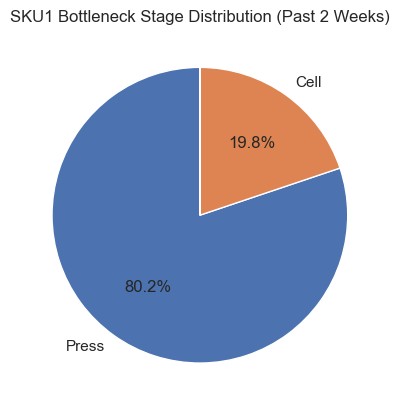

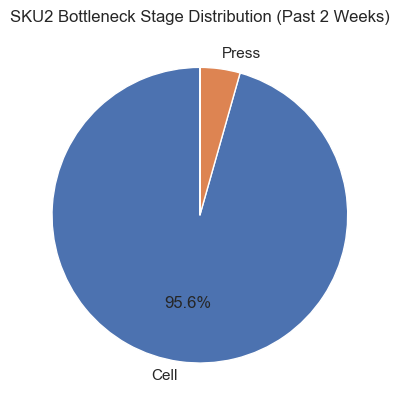

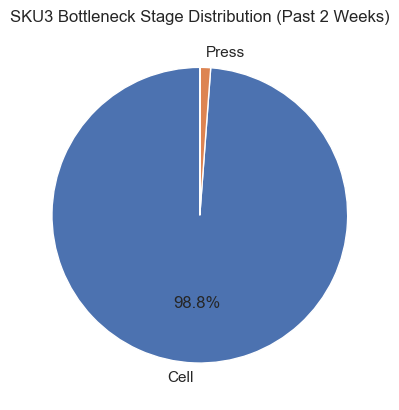

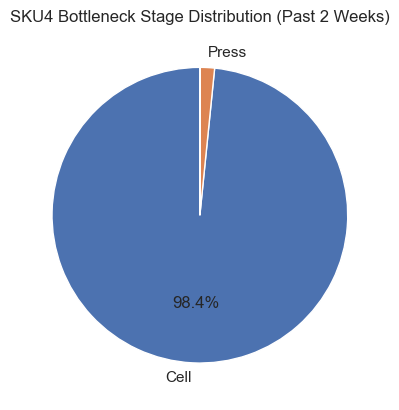

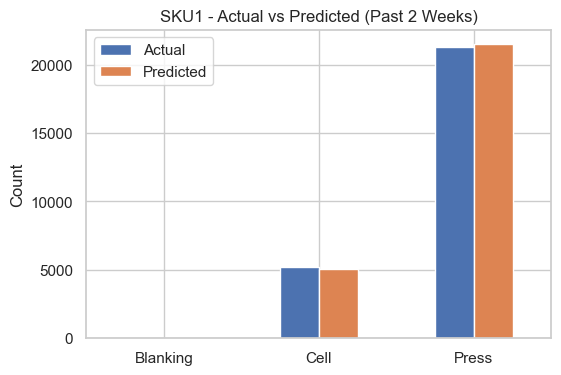

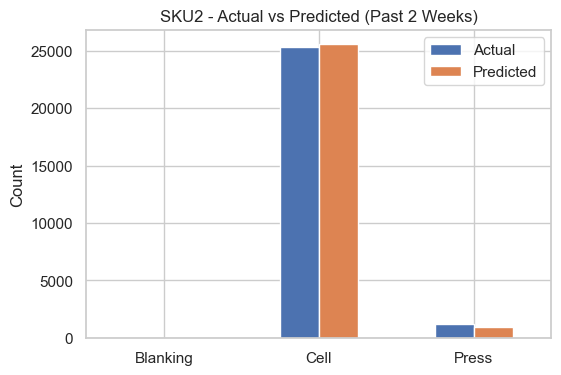

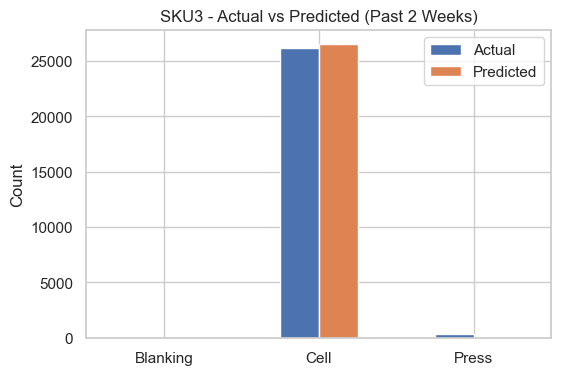

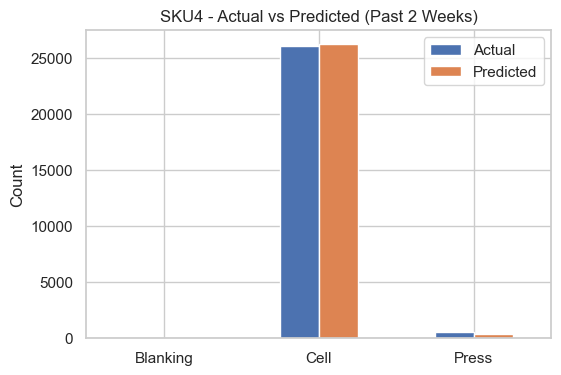

Ïò§Îäò ÎÇ†Ïßú: 1970-01-01

SKU1 Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° Î∂ÑÌè¨:
Press    106857
Cell      25819
Name: count, dtype: int64

SKU2 Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° Î∂ÑÌè¨:
Cell     126859
Press      5817
Name: count, dtype: int64

SKU3 Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° Î∂ÑÌè¨:
Cell     131314
Press      1362
Name: count, dtype: int64

SKU4 Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° Î∂ÑÌè¨:
Cell     130560
Press      2116
Name: count, dtype: int64


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import datetime

# ================================
# 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
# ================================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# Time Ïª¨Îüº datetime Î≥ÄÌôò (Îç∞Ïù¥ÌÑ∞Ïóê ÎßûÍ≤å ÏàòÏ†ï)
df["Time_Now"] = pd.to_datetime(df["Time_Now"])

# ================================
# 2. SKU Í≤ΩÎ°ú Î∞è Cell Îß§Ìïë Ï†ïÏùò
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# ================================
# 3. Warehouse Î∂ÑÎ∞∞ Î≤°ÌÑ∞Ìôî
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. Î≥ëÎ™© Stage ÎùºÎ≤® ÏÉùÏÑ±
# ================================
labels = {}
for sku, path in sku_paths.items():
    stage_df = pd.DataFrame({
        "Blanking": df[path["blanking"]],
        "Press": df[path["press"]],
        "Cell": sku_cell_vals[sku]
    })
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Í≥ºÍ±∞ 2Ï£º ÌïÑÌÑ∞ÎßÅ
# ================================
end_date = df["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=14)
df_past = df[(df["Time_Now"] >= start_date) & (df["Time_Now"] <= end_date)]

# ================================
# 6. Í≥ºÍ±∞ 2Ï£º Í∏∞Ï§Ä SKUÎ≥Ñ Î≥ëÎ™© Stage Î∂ÑÌè¨ (Ïã§Ï†ú)
# ================================
for sku in sku_paths.keys():
    past_labels = labels[sku].loc[df_past.index]
    counts = past_labels.value_counts()

    # Î†àÏù¥Î∏î Ï°∞Í±¥: Blanking ÎπÑÏú® ÎÇÆÏúºÎ©¥ Ï†úÏô∏
    total = counts.sum()
    labels_to_show = []
    for stage, val in counts.items():
        ratio = val / total
        if stage == "Blanking" and ratio < 0.05:  # 5% ÎØ∏ÎßåÏù¥Î©¥ Î†àÏù¥Î∏î Ïà®ÍπÄ
            labels_to_show.append("")  
        else:
            labels_to_show.append(stage)

    plt.figure()
    plt.pie(counts, labels=labels_to_show, autopct=lambda p: f"{p:.1f}%" if p > 5 else "", 
            startangle=90)
    plt.title(f"{sku} Bottleneck Stage Distribution (Past 2 Weeks)")
    plt.show()

# ================================
# 7. Ïã§Ï†ú vs ÏòàÏ∏° (Í≥ºÍ±∞ 2Ï£º)
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]

X_past = df_past[feature_cols]

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]

    X_train, X_test, y_train, y_test = train_test_split(
        X_past, y_past, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    compare_df = pd.DataFrame({
        "Actual": pd.Series(y_test).value_counts(),
        "Predicted": pd.Series(y_pred).value_counts()
    }).fillna(0)

    compare_df.plot(kind="bar", figsize=(6,4))
    plt.title(f"{sku} - Actual vs Predicted (Past 2 Weeks)")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# ================================
# 8. Ïò§ÎäòÏùò SKUÎ≥Ñ Î≥ëÎ™© Stage ÏòàÏ∏°
# ================================
df_today = df[df["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

print("Ïò§Îäò ÎÇ†Ïßú:", end_date.date())
for sku in sku_paths.keys():
    y_all = labels[sku]  # Ï†ÑÏ≤¥ ÎùºÎ≤®
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)  # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ
    preds_today = clf.predict(X_today)
    counts_today = pd.Series(preds_today).value_counts()
    print(f"\n{sku} Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° Î∂ÑÌè¨:")
    print(counts_today)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1. Í≥ºÍ±∞ 2Ï£º Actual vs Predicted (Ìëú)
# -----------------------------
past_result_tables = {}

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X_past, y_past, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    compare_df = pd.DataFrame({
        "Actual": pd.Series(y_test).value_counts(),
        "Predicted": pd.Series(y_pred).value_counts()
    }).fillna(0).astype(int)

    past_result_tables[sku] = compare_df

# -----------------------------
# 2. Ïò§Îäò Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° (Ìëú)
# -----------------------------
df_today = df[df["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

today_result_tables = {}
for sku in sku_paths.keys():
    y_all = labels[sku]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    preds_today = clf.predict(X_today)
    counts_today = pd.Series(preds_today).value_counts()
    today_result_tables[sku] = counts_today

# -----------------------------
# 3. Ï∂úÎ†•
# -----------------------------
print("=== Í≥ºÍ±∞ 2Ï£ºÍ∞Ñ Actual vs Predicted Î≥ëÎ™© Stage (SKUÎ≥Ñ) ===\n")
for sku, table in past_result_tables.items():
    print(f"[{sku}]")
    print(table, "\n")

print("\n=== Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° (SKUÎ≥Ñ) ===\n")
for sku, table in today_result_tables.items():
    print(f"[{sku}]")
    print(table, "\n")

=== Í≥ºÍ±∞ 2Ï£ºÍ∞Ñ Actual vs Predicted Î≥ëÎ™© Stage (SKUÎ≥Ñ) ===

[SKU1]
          Actual  Predicted
Blanking       1          0
Cell        5222       5022
Press      21313      21514 

[SKU2]
          Actual  Predicted
Blanking       1          0
Cell       25324      25561
Press       1211        975 

[SKU3]
          Actual  Predicted
Blanking       1          0
Cell       26207      26503
Press        328         33 

[SKU4]
          Actual  Predicted
Blanking       1          0
Cell       26055      26191
Press        480        345 


=== Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏° (SKUÎ≥Ñ) ===

[SKU1]
Press    106857
Cell      25819
Name: count, dtype: int64 

[SKU2]
Cell     126859
Press      5817
Name: count, dtype: int64 

[SKU3]
Cell     131314
Press      1362
Name: count, dtype: int64 

[SKU4]
Cell     130560
Press      2116
Name: count, dtype: int64 



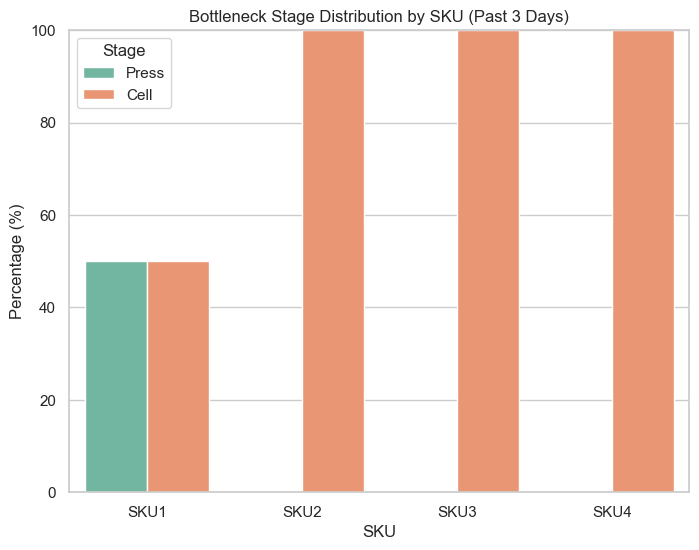

=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ ÎÇ†ÏßúÎ≥Ñ Actual/Predicted + Ïò§Îäò ÏòàÏ∏° Stage ===

+----+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|    | SKU   | 06-27_A   | 06-28_A   | 06-29_A   | 06-30_A   | 06-27_P   | 06-28_P   | 06-29_P   | 06-30_P   | Today   |
+====+=======+===========+===========+===========+===========+===========+===========+===========+===========+=========+
|  0 | SKU1  | Press     | Cell      | Press     | Cell      | Press     | Cell      | Press     | Cell      | Cell    |
+----+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|  1 | SKU2  | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell    |
+----+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|  2 | SKU3  | Cell      | Cell      | Cell      | Cell      | Cell      | Cell 

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
# ================================
file_path = "./subset_20240101_20250630_fullcols.csv"
df = pd.read_csv(file_path)

# ÎÇ†Ïßú Î≥ÄÌôò
df["Time_Now"] = pd.to_datetime(df["Time_Now"])

# ÌïòÎ£®Îãπ 1ÌñâÎßå ÎÇ®Í∏∞Í∏∞ (ÎßàÏßÄÎßâ row Í∏∞Ï§Ä)
df_daily = df.groupby(df["Time_Now"].dt.date).tail(1).reset_index(drop=True)

# ================================
# 2. SKU Í≤ΩÎ°ú Î∞è Cell Îß§Ìïë Ï†ïÏùò
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# ================================
# 3. Warehouse Î∂ÑÎ∞∞ Î≤°ÌÑ∞Ìôî
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df_daily.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df_daily[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. Î≥ëÎ™© Stage ÎùºÎ≤® ÏÉùÏÑ±
# ================================
labels = {}
for sku, path in sku_paths.items():
    stage_df = pd.DataFrame({
        "Blanking": df_daily[path["blanking"]],
        "Press": df_daily[path["press"]],
        "Cell": sku_cell_vals[sku]
    })
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Feature ÏÑ†ÌÉù
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X_full = df_daily[feature_cols]

# ================================
# 6. Í≥ºÍ±∞ 3Ïùº ÌïÑÌÑ∞ÎßÅ
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 7. Í≥ºÍ±∞ 3Ïùº: SKUÎ≥Ñ Ïã§Ï†ú Î≥ëÎ™© Î∂ÑÌè¨ (ÎßâÎåÄÍ∑∏ÎûòÌîÑ, X=SKU)
# ================================
records = []
for sku in sku_paths.keys():
    past_labels = labels[sku].loc[df_past.index]
    counts = past_labels.value_counts(normalize=True) * 100

    if "Blanking" in counts and counts["Blanking"] < 5:
        counts = counts.drop("Blanking")

    for stage, val in counts.items():
        records.append({"SKU": sku, "Stage": stage, "Percentage": val})

plot_df = pd.DataFrame(records)

plt.figure(figsize=(8,6))
sns.barplot(data=plot_df, x="SKU", y="Percentage", hue="Stage", palette="Set2")
plt.title("Bottleneck Stage Distribution by SKU (Past 3 Days)")
plt.ylabel("Percentage (%)")
plt.xlabel("SKU")
plt.ylim(0, 100)
plt.legend(title="Stage")
plt.show()

# ================================
# 8. Í≥ºÍ±∞ 3Ïùº: ÎÇ†ÏßúÎ≥Ñ Actual vs Predicted
# ================================
history_records = []

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        history_records.append({
            "Date": date,
            "SKU": sku,
            "Actual Stage": actual,
            "Predicted Stage": pred
        })

df_history = pd.DataFrame(history_records)

# ================================
# 9. Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏°
# ================================
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

today_preds = {}
for sku in sku_paths.keys():
    y_all = labels[sku]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds[sku] = pred_today

df_history["Today Predicted Stage"] = df_history["SKU"].map(today_preds)

# -------------------------------
# 10. Ï∂úÎ†• (ÌîºÎ≤óÎêú ÌÖåÏù¥Î∏î: ÎÇ†ÏßúÎ•º Í∞ÄÎ°úÏ∂ïÏúºÎ°ú)
# -------------------------------
df_pivot = df_history.pivot(index="SKU", columns="Date", values=["Actual Stage","Predicted Stage"])

# Ïª¨Îüº Ï†ïÎ¶¨ (ÏßßÍ≤å)
df_pivot.columns = [f"{col[1].strftime('%m-%d')}_{'A' if col[0]=='Actual Stage' else 'P'}"
                    for col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

# Ïò§Îäò ÏòàÏ∏° Ï∂îÍ∞Ä
df_pivot["Today"] = df_pivot["SKU"].map(today_preds)

# ÏΩòÏÜî Ï∂úÎ†• (ÏßßÏùÄ Ïª¨ÎüºÎ™Ö)
print("=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ ÎÇ†ÏßúÎ≥Ñ Actual/Predicted + Ïò§Îäò ÏòàÏ∏° Stage ===\n")
print(tabulate(df_pivot, headers="keys", tablefmt="grid"))

# -------------------------------
# 11. Ï†ÄÏû• (ÏóëÏÖÄ/CSV)
# -------------------------------
output_path = "./bottleneck_summary.xlsx"
df_pivot.to_excel(output_path, index=False)
print(f"\nüëâ Í≤∞Í≥ºÎ•º ÏóëÏÖÄÎ°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§: {output_path}")

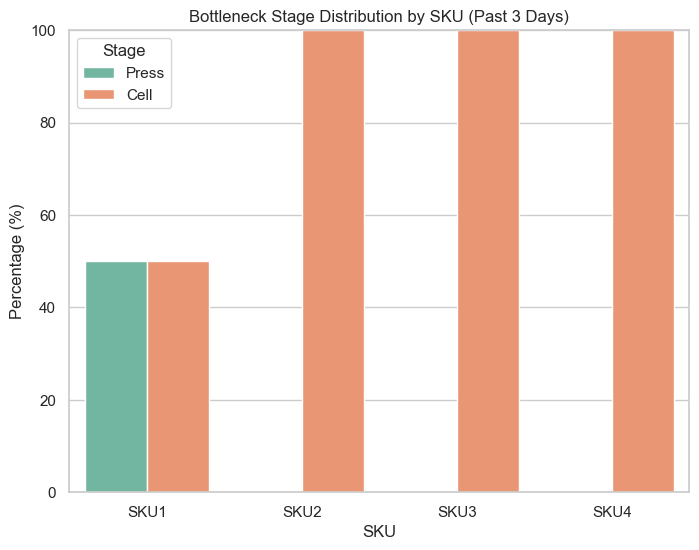

=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ Actual vs Predicted (ÏùºÏπò Ïó¨Î∂Ä Ìè¨Ìï®) + Ïò§Îäò ÏòàÏ∏° Stage ===

+----+-------+----------------------+--------------------+----------------------+--------------------+-------------+
|    | SKU   | 2025-06-27           | 2025-06-28         | 2025-06-29           | 2025-06-30         | Ïò§Îäò_ÏòàÏ∏°   |
+====+=======+======================+====================+======================+====================+=============+
|  0 | SKU1  | Press (ÏòàÏ∏°:Press ‚úî) | Cell (ÏòàÏ∏°:Cell ‚úî) | Press (ÏòàÏ∏°:Press ‚úî) | Cell (ÏòàÏ∏°:Cell ‚úî) | Cell        |
+----+-------+----------------------+--------------------+----------------------+--------------------+-------------+
|  1 | SKU2  | Cell (ÏòàÏ∏°:Cell ‚úî)   | Cell (ÏòàÏ∏°:Cell ‚úî) | Cell (ÏòàÏ∏°:Cell ‚úî)   | Cell (ÏòàÏ∏°:Cell ‚úî) | Cell        |
+----+-------+----------------------+--------------------+----------------------+--------------------+-------------+
|  2 | SKU3  | Cell (ÏòàÏ∏°:Cell ‚úî)   | Cell (ÏòàÏ∏°:C

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
# ================================
file_path = "./subset_20240101_20250630_fullcols.csv"
df = pd.read_csv(file_path)

# ÎÇ†Ïßú Î≥ÄÌôò
df["Time_Now"] = pd.to_datetime(df["Time_Now"])

# ÌïòÎ£®Îãπ 1ÌñâÎßå ÎÇ®Í∏∞Í∏∞ (ÎßàÏßÄÎßâ row Í∏∞Ï§Ä)
df_daily = df.groupby(df["Time_Now"].dt.date).tail(1).reset_index(drop=True)

# ================================
# 2. SKU Í≤ΩÎ°ú Î∞è Cell Îß§Ìïë Ï†ïÏùò
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# ================================
# 3. Warehouse Î∂ÑÎ∞∞ Î≤°ÌÑ∞Ìôî
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df_daily.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df_daily[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. Î≥ëÎ™© Stage ÎùºÎ≤® ÏÉùÏÑ±
# ================================
labels = {}
for sku, path in sku_paths.items():
    stage_df = pd.DataFrame({
        "Blanking": df_daily[path["blanking"]],
        "Press": df_daily[path["press"]],
        "Cell": sku_cell_vals[sku]
    })
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Feature ÏÑ†ÌÉù
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X_full = df_daily[feature_cols]

# ================================
# 6. Í≥ºÍ±∞ 3Ïùº ÌïÑÌÑ∞ÎßÅ
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 7. Í≥ºÍ±∞ 3Ïùº: SKUÎ≥Ñ Ïã§Ï†ú Î≥ëÎ™© Î∂ÑÌè¨ (ÎßâÎåÄÍ∑∏ÎûòÌîÑ, X=SKU)
# ================================
records = []
for sku in sku_paths.keys():
    past_labels = labels[sku].loc[df_past.index]
    counts = past_labels.value_counts(normalize=True) * 100

    if "Blanking" in counts and counts["Blanking"] < 5:
        counts = counts.drop("Blanking")

    for stage, val in counts.items():
        records.append({"SKU": sku, "Stage": stage, "Percentage": val})

plot_df = pd.DataFrame(records)

plt.figure(figsize=(8,6))
sns.barplot(data=plot_df, x="SKU", y="Percentage", hue="Stage", palette="Set2")
plt.title("Bottleneck Stage Distribution by SKU (Past 3 Days)")
plt.ylabel("Percentage (%)")
plt.xlabel("SKU")
plt.ylim(0, 100)
plt.legend(title="Stage")
plt.show()

# ================================
# 8. Í≥ºÍ±∞ 3Ïùº: ÎÇ†ÏßúÎ≥Ñ Actual vs Predicted
# ================================
history_records = []

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        history_records.append({
            "Date": date,
            "SKU": sku,
            "Actual Stage": actual,
            "Predicted Stage": pred
        })

df_history = pd.DataFrame(history_records)

# ================================
# 9. Ïò§Îäò Î≥ëÎ™© Stage ÏòàÏ∏°
# ================================
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

today_preds = {}
for sku in sku_paths.keys():
    y_all = labels[sku]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds[sku] = pred_today

df_history["Today Predicted Stage"] = df_history["SKU"].map(today_preds)

# -------------------------------
# 10. Ï∂úÎ†• (ÎÇ†ÏßúÎ≥Ñ 1Ïª¨Îüº: Ïã§Ï†ú + ÏòàÏ∏° + ÏùºÏπòÏó¨Î∂Ä)
# -------------------------------
records_summary = []

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    # ÎÇ†ÏßúÎ≥Ñ Í∏∞Î°ù
    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        match = "‚úî" if actual == pred else "‚ùå"
        cell_value = f"{actual} (ÏòàÏ∏°:{pred} {match})"
        records_summary.append({"SKU": sku, "Date": date, "Result": cell_value})

df_summary = pd.DataFrame(records_summary)

# Pivot ‚Üí ÎÇ†ÏßúÎ≥Ñ 1Í∞ú Ïª¨ÎüºÎßå
df_pivot = df_summary.pivot(index="SKU", columns="Date", values="Result").reset_index()

# Ïò§Îäò ÏòàÏ∏° Ï∂îÍ∞Ä
df_pivot["Ïò§Îäò_ÏòàÏ∏°"] = df_pivot["SKU"].map(today_preds)

# Ï∂úÎ†•
print("=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ Actual vs Predicted (ÏùºÏπò Ïó¨Î∂Ä Ìè¨Ìï®) + Ïò§Îäò ÏòàÏ∏° Stage ===\n")
print(tabulate(df_pivot, headers="keys", tablefmt="grid"))

# -------------------------------
# 11. Ï†ÄÏû• (ÏóëÏÖÄ/CSV)
# -------------------------------
output_path = "./bottleneck_summary.xlsx"
df_pivot.to_excel(output_path, index=False)
print(f"\nüëâ Í≤∞Í≥ºÎ•º ÏóëÏÖÄÎ°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§: {output_path}")

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows: ÎßëÏùÄ Í≥†Îîï, Mac: AppleGothic, Linux: NanumGothic Îì±)
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'NanumGothic'  # Linux

# ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ
mpl.rcParams['axes.unicode_minus'] = False

In [42]:
import matplotlib as mpl
from matplotlib import font_manager

# ÏÇ¨Ïö©Ìï† Ìè∞Ìä∏ ÌõÑÎ≥¥
font_candidates = ["Malgun Gothic", "NanumGothic", "AppleGothic", "Noto Sans CJK KR"]

for f in font_candidates:
    if f in [x.name for x in font_manager.fontManager.ttflist]:
        mpl.rc("font", family=f)
        break

mpl.rcParams["axes.unicode_minus"] = False  # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ Í≥µÏ†ïÎ≥Ñ Actual vs Predicted (ÏùºÏπò Ïó¨Î∂Ä Ìè¨Ìï®) + Ïò§Îäò ÏòàÏ∏° ===

+----+--------------+--------------------+--------------------+--------------------+--------------------+-------------+
|    | StageGroup   | 2025-06-27         | 2025-06-28         | 2025-06-29         | 2025-06-30         | Ïò§Îäò_ÏòàÏ∏°   |
+====+==============+====================+====================+====================+====================+=============+
|  0 | Blanking     | SKU1 (ÏòàÏ∏°:SKU1 ‚úî) | SKU4 (ÏòàÏ∏°:SKU4 ‚úî) | SKU4 (ÏòàÏ∏°:SKU4 ‚úî) | SKU4 (ÏòàÏ∏°:SKU4 ‚úî) | SKU4        |
+----+--------------+--------------------+--------------------+--------------------+--------------------+-------------+
|  1 | Press        | P1 (ÏòàÏ∏°:P1 ‚úî)     | P2 (ÏòàÏ∏°:P2 ‚úî)     | P1 (ÏòàÏ∏°:P1 ‚úî)     | P2 (ÏòàÏ∏°:P2 ‚úî)     | P2          |
+----+--------------+--------------------+--------------------+--------------------+--------------------+-------------+
|  2 | Warehouse    | W1 (ÏòàÏ∏

C:\Users\KDT6\AppData\Local\Temp\ipykernel_21544\3055458981.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontweight="bold")


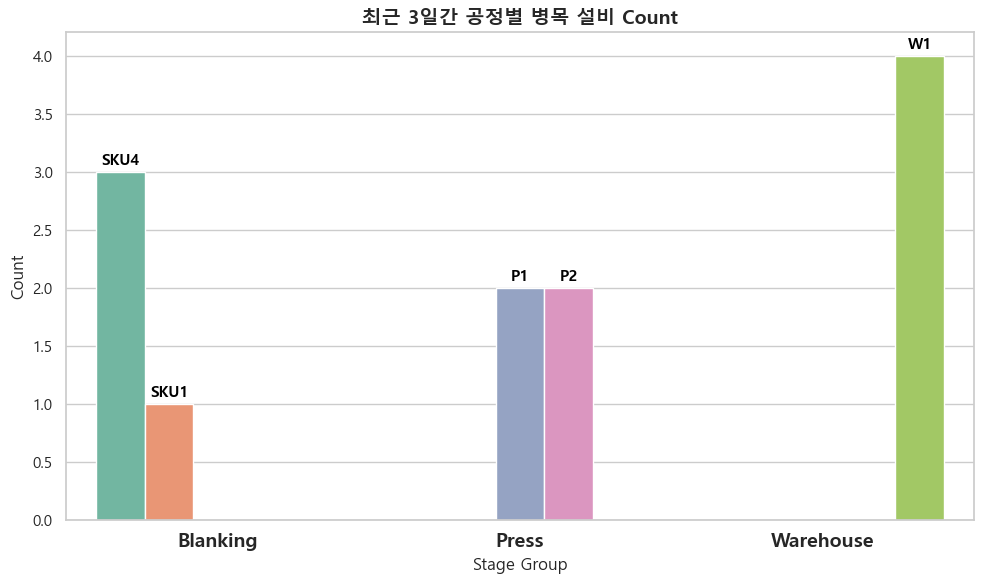

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 0. Ïú†Ìã∏ Ìï®Ïàò
# ================================
def clean_name(x: str) -> str:
    """_Queue, Blanking_, Press, Warehouse Ï†ëÎëêÏÇ¨ Ï†úÍ±∞"""
    x = str(x)
    x = x.replace("_Queue", "")
    x = x.replace("Blanking_", "")
    x = x.replace("Press", "P")        # Press1 ‚Üí P1
    x = x.replace("Warehouse_", "W")   # Warehouse_2 ‚Üí W2
    x = x.replace("Warehouse", "W")    # Warehouse1 ‚Üí W1
    return x

# ================================
# 1. Í≥µÏ†ï Í∑∏Î£π Ï†ïÏùò
# ================================
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Warehouse": [f"Warehouse{i}_Queue" if i==1 else f"Warehouse_{i}_Queue" for i in range(1,5)]
}

# ================================
# 2. Î≥ëÎ™© ÎùºÎ≤® ÏÉùÏÑ± (Ïã§Ï†úÍ∞í)
# ================================
labels_stage = {}
for stage, cols in stage_groups.items():
    labels_stage[stage] = df_daily[cols].idxmax(axis=1)

# ================================
# 3. Í≥ºÍ±∞ 3Ïùº ÌïÑÌÑ∞ÎßÅ
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 4. Í≥ºÍ±∞ 3Ïùº: Actual vs Predicted (Í≥µÏ†ïÎ≥Ñ)
# ================================
records_stage = []

for stage, cols in stage_groups.items():
    y_past = labels_stage[stage].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        match = "‚úî" if actual == pred else "‚ùå"
        cell_value = f"{clean_name(actual)} (ÏòàÏ∏°:{clean_name(pred)} {match})"
        records_stage.append({"StageGroup": stage, "Date": date, "Result": cell_value})

df_stage_summary = pd.DataFrame(records_stage)

# ================================
# 5. Pivot: ÎÇ†ÏßúÎ≥Ñ 1Ïª¨ÎüºÏî©
# ================================
df_stage_pivot = df_stage_summary.pivot(index="StageGroup", columns="Date", values="Result").reset_index()

# Ïò§Îäò ÏòàÏ∏° Ï∂îÍ∞Ä
today_preds_stage = {}
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

for stage, cols in stage_groups.items():
    y_all = labels_stage[stage]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds_stage[stage] = clean_name(pred_today)

df_stage_pivot["Ïò§Îäò_ÏòàÏ∏°"] = df_stage_pivot["StageGroup"].map(today_preds_stage)

# ================================
# 6. Ï∂úÎ†•
# ================================
print("=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ Í≥µÏ†ïÎ≥Ñ Actual vs Predicted (ÏùºÏπò Ïó¨Î∂Ä Ìè¨Ìï®) + Ïò§Îäò ÏòàÏ∏° ===\n")
print(tabulate(df_stage_pivot, headers="keys", tablefmt="grid"))

# ================================
# 7. Í≥ºÍ±∞ 3Ïùº: Í≥µÏ†ïÎ≥Ñ Ïã§Ï†ú Î≥ëÎ™© Î∂ÑÌè¨ (ÎßâÎåÄÍ∑∏ÎûòÌîÑ, X=StageGroup)
# ================================
records = []
for stage, cols in stage_groups.items():
    past_labels = labels_stage[stage].loc[df_past.index]
    counts = past_labels.value_counts()

    for eq, val in counts.items():
        records.append({
            "StageGroup": stage,
            "Equipment": clean_name(eq),
            "Count": val
        })

plot_df = pd.DataFrame(records)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=plot_df, x="StageGroup", y="Count", hue="Equipment", palette="Set2")

# ÎßâÎåÄ ÎÅùÏóê ÎùºÎ≤® ÌëúÏãú
for p, (stage, eq) in zip(ax.patches, plot_df[["StageGroup","Equipment"]].values):
    ax.annotate(eq,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, fontweight="bold", color="black",
                xytext=(0, 2), textcoords="offset points")

# Ï∂ï ÎùºÎ≤® Î∞è ÌÉÄÏù¥ÌãÄ
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Stage Group", fontsize=12)
ax.set_title("ÏµúÍ∑º 3ÏùºÍ∞Ñ Í≥µÏ†ïÎ≥Ñ Î≥ëÎ™© ÏÑ§ÎπÑ Count", fontsize=14, fontweight="bold")

# XÏ∂ï ÎààÍ∏à(label) ÌÅ¨Í≤å ÏÑ§Ï†ï
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontweight="bold")

# Î≤îÎ°Ä Ï†úÍ±∞
ax.legend_.remove()
plt.tight_layout()
plt.show()

=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ Í≥µÏ†ïÎ≥Ñ Actual vs Predicted (ÏùºÏπò Ïó¨Î∂Ä Ìè¨Ìï®) + Ïò§Îäò ÏòàÏ∏° ===

+----+--------------+----------------------+----------------------+----------------------+----------------------+-------------+
|    | StageGroup   | 2025-06-27           | 2025-06-28           | 2025-06-29           | 2025-06-30           | Ïò§Îäò_ÏòàÏ∏°   |
+====+==============+======================+======================+======================+======================+=============+
|  0 | Blanking     | SKU1 (ÏòàÏ∏°:SKU1 ‚úî)   | SKU4 (ÏòàÏ∏°:SKU4 ‚úî)   | SKU4 (ÏòàÏ∏°:SKU4 ‚úî)   | SKU4 (ÏòàÏ∏°:SKU4 ‚úî)   | SKU4        |
+----+--------------+----------------------+----------------------+----------------------+----------------------+-------------+
|  1 | Press        | P1 (ÏòàÏ∏°:P1 ‚úî)       | P2 (ÏòàÏ∏°:P2 ‚úî)       | P1 (ÏòàÏ∏°:P1 ‚úî)       | P2 (ÏòàÏ∏°:P2 ‚úî)       | P2          |
+----+--------------+----------------------+----------------------+----------------------+-------------

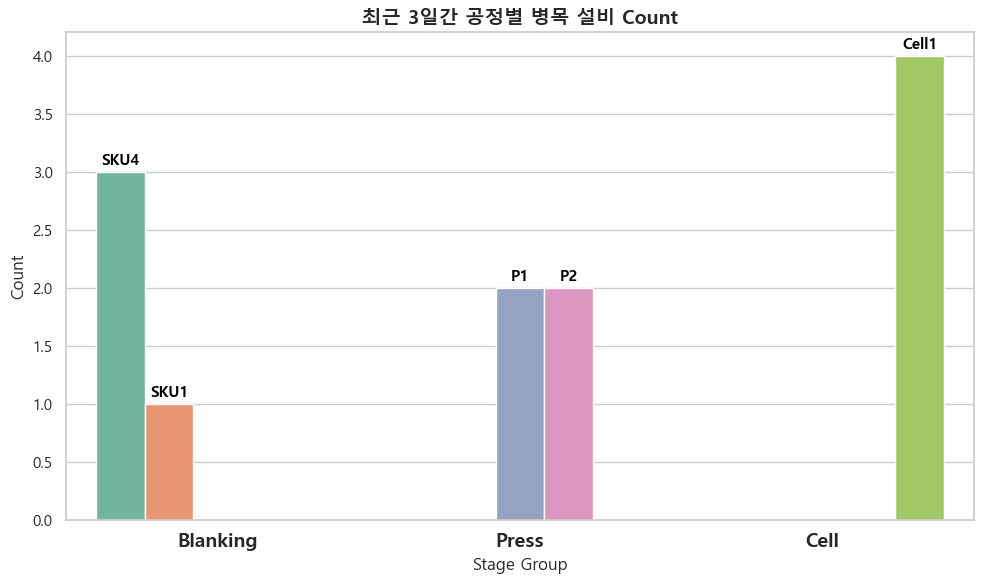

In [45]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 0. Ïú†Ìã∏ Ìï®Ïàò
# ================================
def clean_name(x: str) -> str:
    """_Queue, Blanking_, Press, Warehouse Ï†ëÎëêÏÇ¨ Ï†úÍ±∞ + Warehouse ‚Üí Cell"""
    x = str(x)
    x = x.replace("_Queue", "")
    x = x.replace("Blanking_", "")
    x = x.replace("Press", "P")             # Press1 ‚Üí P1
    x = x.replace("Warehouse_", "Cell")     # Warehouse_2 ‚Üí Cell2
    x = x.replace("Warehouse", "Cell")      # Warehouse1 ‚Üí Cell1
    return x

# ================================
# 1. Í≥µÏ†ï Í∑∏Î£π Ï†ïÏùò
# ================================
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Cell": [f"Warehouse{i}_Queue" if i==1 else f"Warehouse_{i}_Queue" for i in range(1,5)]
}

# ================================
# 2. Î≥ëÎ™© ÎùºÎ≤® ÏÉùÏÑ± (Ïã§Ï†úÍ∞í)
# ================================
labels_stage = {}
for stage, cols in stage_groups.items():
    labels_stage[stage] = df_daily[cols].idxmax(axis=1)

# ================================
# 3. Í≥ºÍ±∞ 3Ïùº ÌïÑÌÑ∞ÎßÅ
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 4. Í≥ºÍ±∞ 3Ïùº: Actual vs Predicted (Í≥µÏ†ïÎ≥Ñ)
# ================================
records_stage = []

for stage, cols in stage_groups.items():
    y_past = labels_stage[stage].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        match = "‚úî" if actual == pred else "‚ùå"
        cell_value = f"{clean_name(actual)} (ÏòàÏ∏°:{clean_name(pred)} {match})"
        records_stage.append({"StageGroup": stage, "Date": date, "Result": cell_value})

df_stage_summary = pd.DataFrame(records_stage)

# ================================
# 5. Pivot: ÎÇ†ÏßúÎ≥Ñ 1Ïª¨ÎüºÏî©
# ================================
df_stage_pivot = df_stage_summary.pivot(index="StageGroup", columns="Date", values="Result").reset_index()

# Ïò§Îäò ÏòàÏ∏° Ï∂îÍ∞Ä
today_preds_stage = {}
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

for stage, cols in stage_groups.items():
    y_all = labels_stage[stage]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds_stage[stage] = clean_name(pred_today)

df_stage_pivot["Ïò§Îäò_ÏòàÏ∏°"] = df_stage_pivot["StageGroup"].map(today_preds_stage)

# ================================
# 6. Ï∂úÎ†• (StageGroup ÏàúÏÑú Î≥¥Ïû•)
# ================================
print("=== Í≥ºÍ±∞ 3ÏùºÍ∞Ñ Í≥µÏ†ïÎ≥Ñ Actual vs Predicted (ÏùºÏπò Ïó¨Î∂Ä Ìè¨Ìï®) + Ïò§Îäò ÏòàÏ∏° ===\n")

order = ["Blanking", "Press", "Cell"]
df_stage_pivot["StageGroup"] = pd.Categorical(df_stage_pivot["StageGroup"], categories=order, ordered=True)
df_stage_pivot = df_stage_pivot.sort_values("StageGroup").reset_index(drop=True)

print(tabulate(df_stage_pivot, headers="keys", tablefmt="grid"))

# ================================
# 7. Í≥ºÍ±∞ 3Ïùº: Í≥µÏ†ïÎ≥Ñ Ïã§Ï†ú Î≥ëÎ™© Î∂ÑÌè¨ (ÎßâÎåÄÍ∑∏ÎûòÌîÑ, X=StageGroup)
# ================================
records = []
for stage, cols in stage_groups.items():
    past_labels = labels_stage[stage].loc[df_past.index]
    counts = past_labels.value_counts()

    for eq, val in counts.items():
        records.append({
            "StageGroup": stage,
            "Equipment": clean_name(eq),
            "Count": val
        })

plot_df = pd.DataFrame(records)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=plot_df, x="StageGroup", y="Count", hue="Equipment", palette="Set2")

# ÎßâÎåÄ ÎÅùÏóê ÎùºÎ≤® ÌëúÏãú
for p, (stage, eq) in zip(ax.patches, plot_df[["StageGroup","Equipment"]].values):
    ax.annotate(eq,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, fontweight="bold", color="black",
                xytext=(0, 2), textcoords="offset points")

# Ï∂ï ÎùºÎ≤® Î∞è ÌÉÄÏù¥ÌãÄ
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Stage Group", fontsize=12)
ax.set_title("ÏµúÍ∑º 3ÏùºÍ∞Ñ Í≥µÏ†ïÎ≥Ñ Î≥ëÎ™© ÏÑ§ÎπÑ Count", fontsize=14, fontweight="bold")

# XÏ∂ï ÎààÍ∏à(label) ÌÅ¨Í≤å ÏÑ§Ï†ï (set_xticklabels ÎåÄÏã† tick_params ÏÇ¨Ïö©)
ax.tick_params(axis="x", labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")

# Î≤îÎ°Ä Ï†úÍ±∞
ax.legend_.remove()
plt.tight_layout()
plt.show()